In [1]:
# import modules
import uproot, sys, time, math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from scipy.special import betainc
from scipy.stats import norm

# import config functions
from jet_faking_plot_config import getWeight, zbi, sample_dict, getVarDict
from plot_var import variables, variables_data, ntuple_names, ntuple_names_BDT


# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 14
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

In [3]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
path = "/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_ggHyyd_y_BDT_score.root"
f = uproot.open(path)['nominal']
# f.keys()
fb = f.arrays(['run', 'dphi_central_jj', 'dphi_jj'], library='ak')
fb['dphi_central_jj'], fb['dphi_jj']

(<Array [-10, -10, -10, -10, ..., 2.32, -10, 0.586, -10] type='225374 * float32'>,
 <Array [-10, -10, 2.79, -10, ..., 2.5, 0.586, -10] type='225374 * float32'>)

In [2]:
run_number_map = {
    # W+jets
    700777: "Wenu",   700778: "Wenu",   700779: "Wenu",
    700780: "Wmunu",  700781: "Wmunu",  700782: "Wmunu",
    700783: "Wtaunu", 700784: "Wtaunu", 700785: "Wtaunu",
    
    # Z+jets
    700786: "Zee",    700787: "Zee",    700788: "Zee",
    700789: "Zmumu",  700790: "Zmumu",  700791: "Zmumu",
    700792: "Ztautau",700793: "Ztautau",700794: "Ztautau",
    700795: "Znunu",  700796: "Znunu",  700797: "Znunu",
}
run_number_map[700777]


'Wenu'

In [6]:
tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []
ntuple_names = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct', 'data23']
index = 0

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

def print_cut(ntuple_name, fb, label):
    print(f"Unweighted Events {label}: ", len(fb))
    if ntuple_name == 'data23':
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name, jet_faking=True)))
    else: 
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name)))

def dphi_jj_test(fb, index):
    var_tmp = getVarDict(fb, "data23", var_name="dphi_jj")
    dphi_jj_tmp = var_tmp["dphi_jj"]['var']
    var_tmp = getVarDict(fb, "data23", var_name="n_jet_central")
    n_jet_central_tmp = var_tmp["n_jet_central"]['var']
    index += 1
    print("index: ", index,
          "== -999: ", sum(ak.where(dphi_jj_tmp == -999)[0]), 
          "!= -999: ", sum(ak.where(dphi_jj_tmp != -999)[0]),
          "n_jet: ", sum(ak.where(n_jet_central_tmp < 2)[0]))
    return index

for i in range(len(ntuple_names)):
    ucut, wcut = [], []
    start_time = time.time()
    ntuple_name = ntuple_names[i]
    if ntuple_name == 'data23': # data
        path = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/data23_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables_data, library="ak")
        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
                
        mask1 = (ak.firsts(fb['ph_topoetcone40'])-2450.)/ak.firsts(fb['ph_pt']) < 0.1   # jet_faking_photon cut
        fb = fb[mask1]
        fb = fb[fb['n_ph_baseline'] == 1]


    else: # MC
        path = f"/data/tmathew/ntups/mc23d/{ntuple_name}_y.root" 
        path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name}_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables, library="ak")

        # add BDT score to fb
        f_BDT = uproot.open(path_BDT)['nominal']
        fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
        tmp = fb["event"] == fb_BDT["event"]
        if np.all(tmp) == True:
            fb["BDTScore"] = fb_BDT["BDTScore"]
        else: 
            print("Something is wrong, need arranging")

        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
        fb = fb[fb['n_ph'] == 1]

    # Zjets and Wjets (rule out everything except for e->gamma)
    if ntuple_name == 'Zjets' or ntuple_name == 'Wjets':
        mask1 = ak.firsts(fb['ph_truth_type']) == 2
        mask2 = ak.firsts(fb['ph_truth_type']) == 2
        fb = fb[mask1 & mask2]
    
    print_cut(ntuple_name, fb, 'before cut')


    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 100 # trigger cut
    fb = fb[mask1]

    fb = fb[fb['BDTScore'] >= 0.1] # added cut 1

    print_cut(ntuple_name, fb, 'after basic cut')
        

    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0



processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  195671
Weighted Events before cut:  19979.121
Unweighted Events after basic cut:  3763
Weighted Events after basic cut:  379.60068
processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  3242488
Weighted Events before cut:  674497.9
Unweighted Events after basic cut:  5164
Weighted Events after basic cut:  124.29326
processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  3423357
Weighted Events before cut:  249515.86
Unweighted Events after basic cut:  704359
Weighted Events after basic cut:  16750.656
processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1308982
Weighted Events before cut:  427789.75
Unweighted Events after basic cut:  169968
Weighted Events after basic cut:  15736.289
processing file:  /data/tmathew/ntups/mc23d/Wjets_y.root
Unweighted Events before cut:  1962593
Weighted Events bef

Counter({np.str_('Zee'): 4611266, np.str_('Ztautau'): 3834496, np.str_('Znunu'): 2401831, np.str_('Zmumu'): 696488})
Counter({np.str_('Wenu'): 2414618, np.str_('Wtaunu'): 560355, np.str_('Wmunu'): 67011})


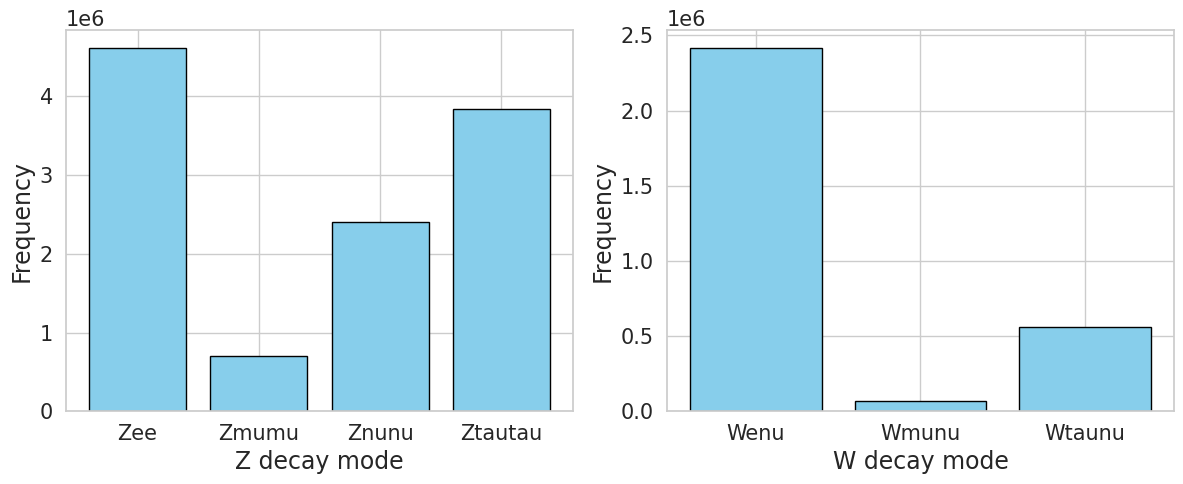

In [16]:
from collections import Counter

fb = tot[0]
run_array_np = ak.to_numpy(fb['run'])
labels = np.vectorize(lambda x: run_number_map.get(int(x), "Unknown"))(run_array_np)

label_counter = Counter(labels)
labels = sorted(label_counter.keys())
print(label_counter)
counts = [label_counter[l] for l in labels]

# Plot
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.bar(labels, counts, color='skyblue', edgecolor='black')

plt.xlabel("Z decay mode")
plt.ylabel("Frequency")
plt.tight_layout()


plt.subplot(122)
fb = tot[1]
run_array_np = ak.to_numpy(fb['run'])
labels = np.vectorize(lambda x: run_number_map.get(int(x), "Unknown"))(run_array_np)

label_counter = Counter(labels)
labels = sorted(label_counter.keys())
print(label_counter)
counts = [label_counter[l] for l in labels]

plt.bar(labels, counts, color='skyblue', edgecolor='black')

plt.xlabel("W decay mode")
plt.ylabel("Frequency")
plt.tight_layout()

plt.show()


6178917
6178917
3033905
3033905


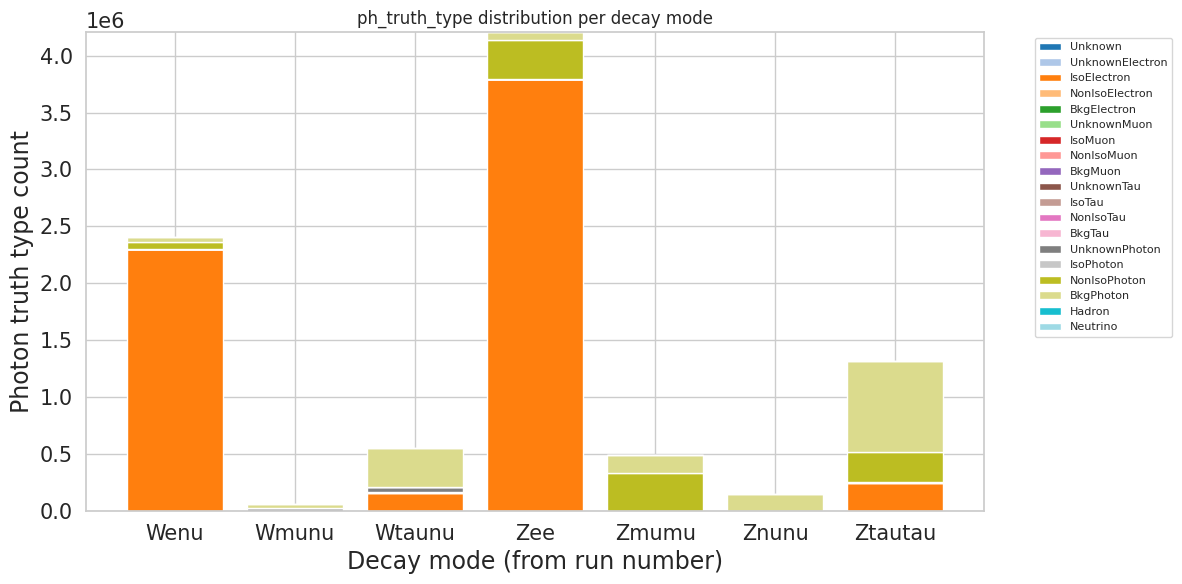

In [15]:
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
import numpy.ma as ma

# ---- Mapping setup ----
truth_type_map = {
    0: "Unknown", 1: "UnknownElectron", 2: "IsoElectron", 3: "NonIsoElectron",
    4: "BkgElectron", 5: "UnknownMuon", 6: "IsoMuon", 7: "NonIsoMuon",
    8: "BkgMuon", 9: "UnknownTau", 10: "IsoTau", 11: "NonIsoTau",
    12: "BkgTau", 13: "UnknownPhoton", 14: "IsoPhoton", 15: "NonIsoPhoton",
    16: "BkgPhoton", 17: "Hadron", 18: "Neutrino"
}

run_number_map = {
    # Zjets
    700786: "Zee", 700787: "Zee", 700788: "Zee",
    700789: "Zmumu", 700790: "Zmumu", 700791: "Zmumu",
    700792: "Ztautau", 700793: "Ztautau", 700794: "Ztautau",
    700795: "Znunu", 700796: "Znunu", 700797: "Znunu",
    # Wjets
    700777: "Wenu", 700778: "Wenu", 700779: "Wenu",
    700780: "Wmunu", 700781: "Wmunu", 700782: "Wmunu",
    700783: "Wtaunu", 700784: "Wtaunu", 700785: "Wtaunu"
}

# ---- Accumulate counts in 2D dict: decay -> truth_type -> count ----
decay_truth_counts = defaultdict(lambda: Counter())

for fb in tot:
    fb = fb[ak.num(fb['ph_eta']) == 1]
    print(len(fb))

    fb = fb[fb['n_ph_baseline']==1] 
    print(len(fb))

    run_array = ak.to_numpy(fb['run'])
    truth_type_array = ak.to_numpy(ak.firsts(fb['ph_truth_type']))


    for run, truth in zip(run_array, truth_type_array):
        decay = run_number_map.get(int(run), "Unknown")

        # Robust check for missing or masked values
        # if truth is None or (hasattr(truth, 'mask') and truth.mask):
        #     continue

        decay_truth_counts[decay][int(truth)] += 1

# ---- Prepare plotting ----
decay_labels = sorted(decay_truth_counts.keys())
truth_type_labels = [truth_type_map[i] for i in range(19)]

# Initialize matrix: shape (len(truth_types), len(decays))
matrix = np.zeros((19, len(decay_labels)))

for j, decay in enumerate(decay_labels):
    for i in range(19):
        matrix[i, j] = decay_truth_counts[decay][i]

# ---- Plotting ----
fig, ax = plt.subplots(figsize=(12, 6))

bottom = np.zeros(len(decay_labels))
colors = plt.cm.tab20(np.linspace(0, 1, 19))

for i in range(19):
    values = matrix[i]
    ax.bar(decay_labels, values, bottom=bottom, label=truth_type_map[i], color=colors[i])
    bottom += values

ax.set_xlabel("Decay mode (from run number)")
ax.set_ylabel("Photon truth type count")
ax.set_title("ph_truth_type distribution per decay mode")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


In [16]:
# Check if Znunu has any hadron-origin photons (truth_type == 17)
hadron_truth_type = 17
znunu_counts = decay_truth_counts.get("Znunu", {})

if znunu_counts[hadron_truth_type] > 0:
    print(f"Znunu has {znunu_counts[hadron_truth_type]} hadron-origin photons.")
else:
    print("Znunu has NO hadron-origin photons.")


Znunu has 1448 hadron-origin photons.


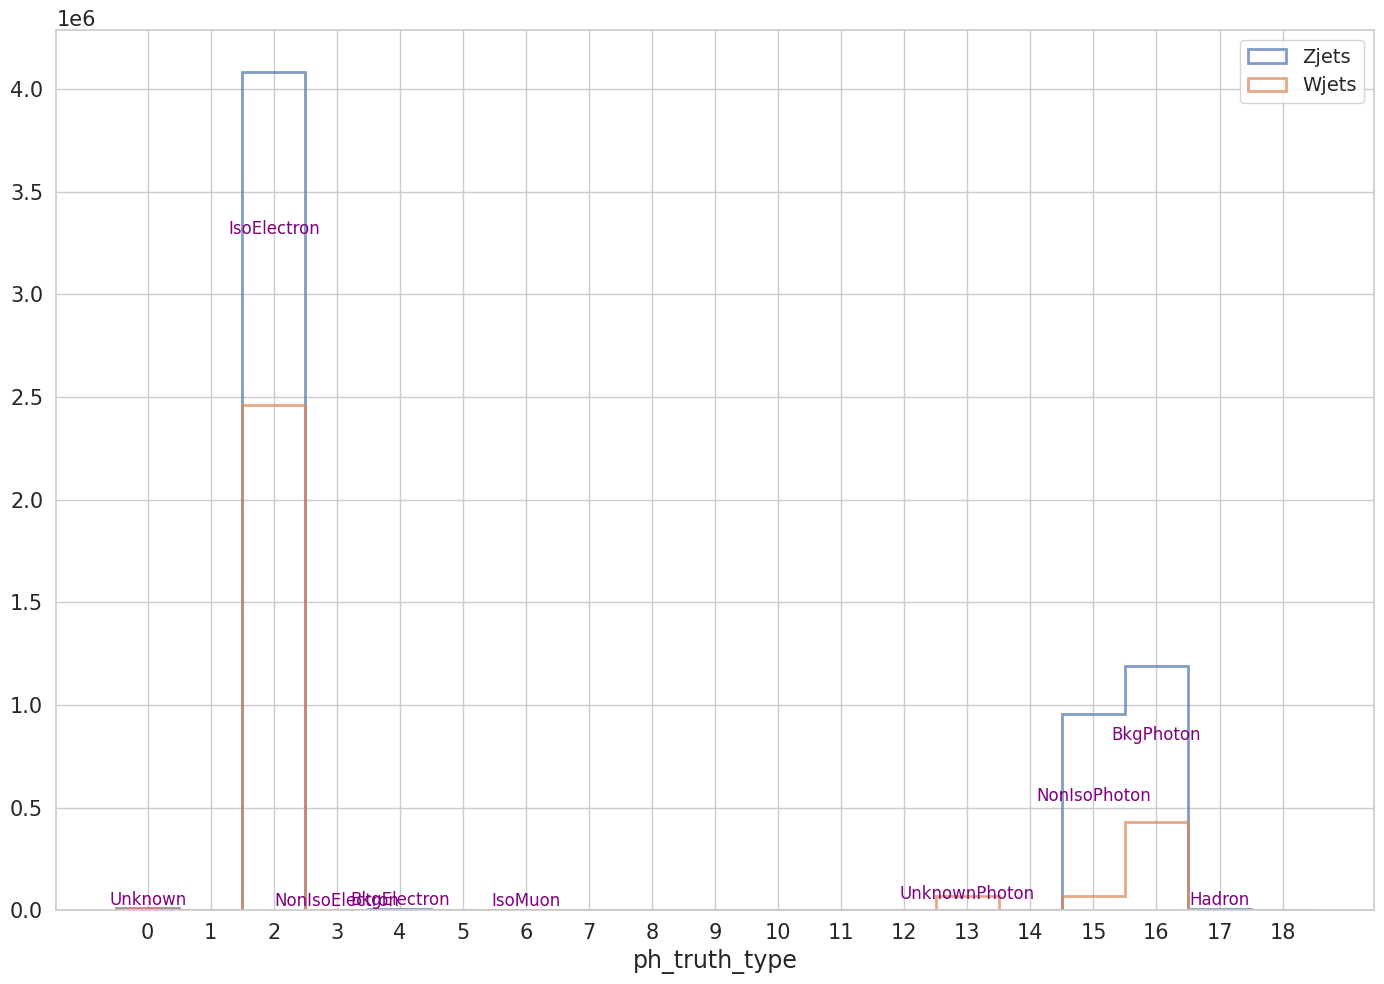

In [ ]:
truth_type_map = {
    0: "Unknown",
    1: "UnknownElectron",
    2: "IsoElectron",
    3: "NonIsoElectron",
    4: "BkgElectron",
    5: "UnknownMuon",
    6: "IsoMuon",
    7: "NonIsoMuon",
    8: "BkgMuon",
    9: "UnknownTau",
    10: "IsoTau",
    11: "NonIsoTau",
    12: "BkgTau",
    13: "UnknownPhoton",
    14: "IsoPhoton",
    15: "NonIsoPhoton",
    16: "BkgPhoton",
    17: "Hadron",
    18: "Neutrino",
}

bins = np.arange(-0.5, 19.5, 1)

# Histogram 1: Zjets
fb = tot[0]
data_zjets = ak.firsts(fb['ph_truth_type'])
counts_zjets, _ = np.histogram(data_zjets, bins=bins)
plt.hist(data_zjets, bins=bins, linewidth=2, histtype='step', alpha=0.7, label="Zjets")

# Histogram 2: Wjets
fb = tot[1]
data_wjets = ak.firsts(fb['ph_truth_type'])
counts_wjets, _ = np.histogram(data_wjets, bins=bins)
plt.hist(data_wjets, bins=bins, linewidth=2, histtype='step', alpha=0.7, label="Wjets")

# Label non-zero bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
total_counts = counts_zjets + counts_wjets
for i, count in enumerate(total_counts):
    if count > 0 and i in truth_type_map:
        plt.text(bin_centers[i], count*0.5, truth_type_map[i],
                 ha='center', va='bottom', color='purple', fontsize=12)

plt.xticks(np.arange(0, 19, 1))
plt.xlabel("ph_truth_type")
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []
ntuple_names = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct', 'data23']

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

def print_cut(ntuple_name, fb, label):
    print(f"Unweighted Events {label}: ", len(fb))
    if ntuple_name == 'data23':
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name, jet_faking=True)))
    else: 
        print(f"Weighted Events {label}: ", sum(getWeight(fb, ntuple_name)))

for i in range(len(ntuple_names)):
    ucut, wcut = [], []
    start_time = time.time()
    ntuple_name = ntuple_names[i]
    if ntuple_name == 'data23': # data
        path = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/data23_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables_data, library="ak")
        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
                
        mask1 = (ak.firsts(fb['ph_topoetcone40'])-2450.)/ak.firsts(fb['ph_pt']) > 0.1   # jet_faking_photon cut
        fb = fb[mask1]
        fb = fb[fb['n_ph_baseline'] == 1]

    else: # MC
        path = f"/data/tmathew/ntups/mc23d/{ntuple_name}_y.root" 
        path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name}_y_BDT_score.root" 
        print('processing file: ', path)
        f = uproot.open(path)['nominal']
        fb = f.arrays(variables, library="ak")

        # add BDT score to fb
        f_BDT = uproot.open(path_BDT)['nominal']
        fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
        tmp = fb["event"] == fb_BDT["event"]
        if np.all(tmp) == True:
            fb["BDTScore"] = fb_BDT["BDTScore"]
        else: 
            print("Something is wrong, need arranging")

        fb = fb[ak.num(fb['ph_eta']) > 0]     # for abs(ak.firsts(fb['ph_eta'])) to have value to the reweighting
        fb = fb[fb['n_ph'] == 1]
        
        # Zjets and Wjets (rule out everything except for e->gamma)
        if ntuple_name == 'Zjets' or ntuple_name == 'Wjets':
            mask = ak.firsts(fb['ph_truth_type']) == 2
            fb = fb[mask]
        
        # goodPV on signal only
        if ntuple_name == 'ggHyyd':
            fb = fb[ak.num(fb['pv_z']) > 0]
            good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
            fb = fb[good_pv_tmp]

    print_cut(ntuple_name, fb, 'before cut')

    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[fb['n_jet_central'] <= 4] # n_jet_central cut (basic cut)

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 100 # trigger cut
    fb = fb[mask1]

    # fb = fb[fb['BDTScore'] >= 0.1] # added cut 1
    

    print_cut(ntuple_name, fb, 'after basic cut')


    ucut.append(len(fb))

    unweighted_acut.append(ucut)
    weighted_acut.append(wcut)
    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  86910
Weighted Events before cut:  8732.756
Unweighted Events after basic cut:  4587
Weighted Events after basic cut:  461.92218
Number of none values:  0
Reading Time for ggHyyd: 4.150322198867798 seconds

processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  3242488
Weighted Events before cut:  674497.9
Unweighted Events after basic cut:  9208
Weighted Events after basic cut:  706.2252
Number of none values:  0
Reading Time for Zjets: 115.44221305847168 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  3423357
Weighted Events before cut:  249515.86
Unweighted Events after basic cut:  1715357
Weighted Events after basic cut:  52655.82
Number of none values:  0
Reading Time for Zgamma: 89.03246665000916 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1308982
Weighted E

In [5]:
# Save data after basic cut to a csv file for BDT input
Vars = [
    'balance', 
    'BDTScore',
    'dmet',
    'dphi_jj',
    'dphi_met_central_jet',
    'dphi_met_phterm',
    'dphi_met_ph',
    'dphi_met_jetterm',
    'dphi_phterm_jetterm',
    'dphi_ph_centraljet1',
    'ph_pt',
    'ph_eta',
    'ph_phi',
    'jet_central_eta',
    'jet_central_pt1',
    'jet_central_pt2',
    'jetterm',
    'jetterm_sumet',
    'metsig',
    'metsigres',
    'met',
    'met_noJVT',
    'metplusph',
    'failJVT_jet_pt1',
    'softerm',
    'n_jet_central'
]

data_list = []

for j in range(len(ntuple_names)):
    process = ntuple_names[j]
    fb = tot[j] 
    
    data_dict = {}
    
    for var in Vars:
        var_config = getVarDict(fb, process, var_name=var)
        data_dict[var] = var_config[var]['var']
    
    weights = getWeight(fb, process)
    data_dict['weights'] = weights
    
    n_events = len(weights)
    data_dict['process'] = [process] * n_events
    label = 1 if process == 'ggHyyd' else 0
    data_dict['label'] = [label] * n_events
    
    df_temp = pd.DataFrame(data_dict)
    data_list.append(df_temp)

df_all = pd.concat(data_list, ignore_index=True)
df_all.head()

df_all.to_csv("/data/jlai/ntups/csv/jet_faking_BDT_input_basic.csv", index=False)


In [4]:
def sel(tot):
    tot2 = []
    for i in range(len(tot)):
        fb2 = tot[i]

        fb2 = fb2[fb2['BDTScore'] >= 0.1]

        dphi_met_phterm_tmp = np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_phterm_phi']))
        fb2 = fb2[dphi_met_phterm_tmp >= 1.35]

        jet_sum_tmp = ak.sum(fb2['jet_central_pt'], axis=-1)
        expr = (fb2['met_tst_et'] + ak.firsts(fb2['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance_tmp = ak.where(jet_sum_tmp != 0, expr, -999)
        mask1 = balance_tmp >= 0.70
        mask2 = balance_tmp == -999
        fb2 = fb2[mask1 | mask2]

        metsig_tmp = fb2['met_tst_sig'] 
        mask1 = metsig_tmp >= 5
        mask2 = metsig_tmp <= 16
        fb2 = fb2[mask1 * mask2]
    
        ph_eta_tmp = np.abs(ak.firsts(fb2['ph_eta']))
        fb2 = fb2[ph_eta_tmp <= 1.75]

        dmet_tmp = fb2['met_tst_noJVT_et'] - fb2['met_tst_et']
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        fb2 = fb2[mask1 * mask2]

        dphi_met_jetterm_tmp = np.where(fb2['met_jetterm_et'] != 0,   # added cut 5
                                np.arccos(np.cos(fb2['met_tst_phi'] - fb2['met_jetterm_phi'])),
                                -999)
        fb2 = fb2[dphi_met_jetterm_tmp <= 0.65]

        dphi_jj_tmp = fb2['dphi_central_jj']
        dphi_jj_tmp = ak.where(dphi_jj_tmp == -10, -999, dphi_jj_tmp)
        fb2 = fb2[dphi_jj_tmp <= 2.4]
        
        tot2.append(fb2)
    return tot2

# tot2 = sel(tot)
tot2 = tot

cut_name = 'basic'
# var_config = getVarDict(tot2[0], 'ggHyyd', var_name='balance')
var_config = getVarDict(tot2[0], 'ggHyyd')


for var in var_config:
    # print(var)
    bg_values = []     
    bg_weights = []    
    bg_colors = []     
    bg_labels = []     

    signal_values = [] 
    signal_weights = []
    signal_color = None 
    signal_label = None

    for j in range(len(ntuple_names)):
    # for j in range(len(ntuple_names)-1): # leave dijet out
        process = ntuple_names[j]
        fb = tot2[j]  # TTree
        var_config = getVarDict(fb, process, var_name=var)

        x = var_config[var]['var'] # TBranch
        bins = var_config[var]['bins'] 

        if 'weight' in var_config[var]:  # If weight is there
            weights = var_config[var]['weight']
        else:
            weights = getWeight(fb, process)
        
        sample_info = sample_dict[process]
        color = sample_info['color']
        legend = sample_info['legend']

        
        if process == 'ggHyyd':  # signal
            signal_values.append(x)
            signal_weights.append(weights)
            signal_color = color
            signal_label = legend
        else:   # background
            bg_values.append(x)
            bg_weights.append(weights)
            bg_colors.append(color)
            bg_labels.append(legend)

    fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(12, 13), gridspec_kw={'height_ratios': [9, 4]})

    ax_top.hist(bg_values, bins=bins, weights=bg_weights, color=bg_colors,
                label=bg_labels, stacked=True)

    ax_top.hist(signal_values, bins=bins, weights=signal_weights, color=signal_color,
                label=signal_label, histtype='step', linewidth=2)

    signal_all = np.concatenate(signal_values) if len(signal_values) > 0 else np.array([])
    signal_weights_all = np.concatenate(signal_weights) if len(signal_weights) > 0 else np.array([])

    # Add error bar for signal (top plot)
    if len(signal_all) > 0:
        signal_counts, bin_edges = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
        sum_weights_sq, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all**2)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        signal_errors = np.sqrt(sum_weights_sq)  # Poisson error sqrt(N)

        ax_top.errorbar(bin_centers, signal_counts, yerr=signal_errors, fmt='.', linewidth=2,
                        color=signal_color, capsize=0)

    ax_top.set_yscale('log')
    ax_top.set_ylim(0.0001, 1e11)
    ax_top.set_xlim(bins[0], bins[-1])
    ax_top.minorticks_on()
    ax_top.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax_top.set_ylabel("Events")
    ax_top.legend(ncol=2)
    # ax_top.set_title("vtx_sumPt distribution")

    bg_all = np.concatenate(bg_values) if len(bg_values) > 0 else np.array([])
    bg_weights_all = np.concatenate(bg_weights) if len(bg_weights) > 0 else np.array([])

    # Compute the weighted histogram counts using np.histogram
    S_counts, _ = np.histogram(signal_all, bins=bins, weights=signal_weights_all)
    B_counts, _ = np.histogram(bg_all, bins=bins, weights=bg_weights_all)     

    # Compute per-bin significance
    sig_simple = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_b = np.zeros_like(S_counts, dtype=float)
    sig_s_plus_1p3b = np.zeros_like(S_counts, dtype=float)

    sqrt_B = np.sqrt(B_counts)
    sqrt_SplusB = np.sqrt(S_counts + B_counts)
    sqrt_Splus1p3B = np.sqrt(S_counts + 1.3 * B_counts)

    # Avoid division by zero safely
    sig_simple = np.where(B_counts > 0, S_counts / sqrt_B, 0)
    sig_s_plus_b = np.where((S_counts + B_counts) > 0, S_counts / sqrt_SplusB, 0)
    sig_s_plus_1p3b = np.where((S_counts + 1.3 * B_counts) > 0, S_counts / sqrt_Splus1p3B, 0)

    # Add Binomial ExpZ per bin
    zbi_per_bin = np.array([
        zbi(S_counts[i], B_counts[i], sigma_b_frac=0.3)
        for i in range(len(S_counts))
    ])

    # Compute the bin centers for plotting
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # Compute the total significance: total S / sqrt(total B)
    total_signal = np.sum(S_counts)
    total_bkg = np.sum(B_counts)

    if total_bkg > 0:
        total_sig_simple = total_signal / np.sqrt(total_bkg)
        total_sig_s_plus_b = total_signal / np.sqrt(total_signal + total_bkg)
        total_sig_s_plus_1p3b = total_signal / np.sqrt(total_signal + 1.3 * total_bkg)
        total_sig_binomial = zbi(total_signal, total_bkg, sigma_b_frac=0.3)
    else:
        total_sig_simple = total_sig_s_plus_b = total_sig_s_plus_1p3b = total_sig_binomial = 0

    # --- Plot all significance curves ---
    ax_bot.step(bin_centers, sig_simple, where='mid', color='chocolate', linewidth=2,
                label=f"S/√B = {total_sig_simple:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_b, where='mid', color='tomato', linewidth=2,
                label=f"S/√(S+B) = {total_sig_s_plus_b:.4f}")
    ax_bot.step(bin_centers, sig_s_plus_1p3b, where='mid', color='orange', linewidth=2,
                label=f"S/√(S+1.3B) = {total_sig_s_plus_1p3b:.4f}")
    ax_bot.step(bin_centers, zbi_per_bin, where='mid', color='plum', linewidth=2,
                label=f"Binomial ExpZ = {total_sig_binomial:.4f}")

    ax_bot.set_xlabel(var_config[var]['title'])
    # ax_bot.set_xticks(np.linspace(bins[0], bins[-1], 11))
    ax_bot.set_ylabel("Significance")
    ax_bot.set_ylim(-0.8, 2)
    ax_top.set_xlim(bins[0], bins[-1])

    # Do not set a title on the bottom plot.
    ax_bot.set_title("")

    # Draw a legend with purple text.
    leg = ax_bot.legend()
    for text in leg.get_texts():
        text.set_color('purple')

    plt.xlim(bins[0], bins[-1])
    plt.tight_layout()
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    print(f"successfully saved to ../jets_faking_photons/lumi135/mc23d_{cut_name}cut/{var}_nodijet.png")
    plt.close()
    # plt.show()

    y_true = np.concatenate([np.ones_like(signal_all), np.zeros_like(bg_all)])
    # Use the vtx_sumPt values as the classifier output.
    y_scores = np.concatenate([signal_all, bg_all])
    # Combine the weights for all events.
    y_weights = np.concatenate([signal_weights_all, bg_weights_all])

    # Compute the weighted ROC curve.
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=y_weights)
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    roc_auc = auc(fpr_sorted, tpr_sorted)

    # Create a new figure for the ROC curve.
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, lw=2, color='red', label=f'ROC curve (AUC = {roc_auc:.5f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random chance')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {var}")
    plt.legend(loc="lower right")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()    
    plt.savefig(f"../jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    print(f"successfully saved to ../jets_faking_photons/lumi135/mc23d_{cut_name}cut/roc_curve_{var}.png")
    plt.close()
    # plt.show()


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/vtx_sumPt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_vtx_sumPt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_ph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_ph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_ph_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_ph_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_el_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_el_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_mu_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_mu_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_tau_baseline_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_tau_baseline.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/mt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_mt.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/metsig_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_metsig.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/metsigres_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_metsigres.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/met_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_met.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/met_noJVT_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_met_noJVT.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/met_cst_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_met_cst.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/met_track_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_met_track.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dmet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dmet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/ph_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_ph_pt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/ph_eta_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_ph_eta.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/ph_phi_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_ph_phi.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_eta_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_eta.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_pt1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_pt1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_pt2_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_pt2.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_pt.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_met_phterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_met_phterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_met_ph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_met_ph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_met_jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_met_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_phterm_jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_phterm_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_ph_centraljet1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_ph_centraljet1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_ph_jet1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_ph_jet1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/metplusph_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_metplusph.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/failJVT_jet_pt_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_failJVT_jet_pt.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/failJVT_jet_pt1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_failJVT_jet_pt1.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/softerm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_softerm.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jetterm_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jetterm.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jetterm_sumet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jetterm_sumet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_jet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_jet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_jet_central_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_jet_central.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/n_jet_fwd_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_n_jet_fwd.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_met_central_jet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_met_central_jet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in sqrt
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_timing1_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_timing1.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_timing_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_timing.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/jet_central_emfrac_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_jet_central_emfrac.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/balance_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_balance.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/balance_sumet_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_balance_sumet.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/central_jets_fraction_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_central_jets_fraction.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/trigger_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_trigger.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/dphi_jj_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_dphi_jj.png


/home/jlai/.local/lib/python3.9/site-packages/awkward/_nplikes/array_module.py:251: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/BDTScore_nodijet.png
successfully saved to ../jets_faking_photons/lumi135/mc23d_basiccut/roc_curve_BDTScore.png


In [ ]:
# print out the image list in common_config.js
var_config = getVarDict(tot2[0], 'ggHyyd')

for var in var_config:

    print(f"'mc23d_balancecut/{var}_nodijet.png',")
    print(f"'mc23d_abs_weight_selectioncut/{var}_absWeightSelection.png',")

'mc23d_balancecut/vtx_sumPt_nodijet.png',
'mc23d_abs_weight_selectioncut/vtx_sumPt_absWeightSelection.png',
'mc23d_balancecut/n_ph_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_absWeightSelection.png',
'mc23d_balancecut/n_ph_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_ph_baseline_absWeightSelection.png',
'mc23d_balancecut/n_el_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_el_baseline_absWeightSelection.png',
'mc23d_balancecut/n_mu_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_mu_baseline_absWeightSelection.png',
'mc23d_balancecut/n_tau_baseline_nodijet.png',
'mc23d_abs_weight_selectioncut/n_tau_baseline_absWeightSelection.png',
'mc23d_balancecut/puWeight_nodijet.png',
'mc23d_abs_weight_selectioncut/puWeight_absWeightSelection.png',
'mc23d_balancecut/actualIntPerXing_nodijet.png',
'mc23d_abs_weight_selectioncut/actualIntPerXing_absWeightSelection.png',
'mc23d_balancecut/mt_nodijet.png',
'mc23d_abs_weight_selectioncut/mt_absWeightSelection.png',
'mc23d